<a href="https://colab.research.google.com/github/giuliovv/duckrace_simulator/blob/master/configuration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration
An example of the best configuration for the job

In [1]:
colab = "False" #@param ['True','False']
if colab == "True":
  !pip install duckietown-gym-daffy
  !apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay

  from IPython import display as ipythondisplay

  from pyvirtualdisplay import Display

  display = Display(visible=0, size=(400, 300))
  display.start()


In [2]:
from dataclasses import dataclass

import geometry
import gym_duckietown
import matplotlib.pyplot as plt

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [3]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

Using directly simulator instead of the gym wrapper let us give as action [omega_l, omega_r]

In [4]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[0,0],
    seed=42,
    max_steps=2000,
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [5]:
env.unwrapped.start_pose = [[0.7019999027252197, 0, 0.41029359288296474], 0]

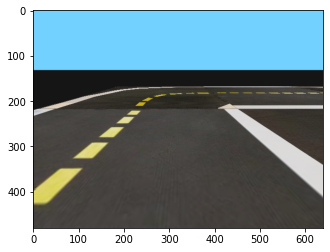

In [6]:
plt.imshow(env.reset())

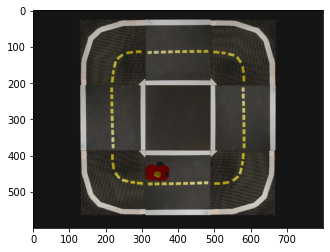

In [7]:
plt.imshow(env.render(mode="top_down"))

In [8]:
env.get_agent_info()

{'Simulator': {'action': [0, 0],
  'lane_position': {'dist': 0.0007935928829647666,
   'dot_dir': 1.0,
   'angle_deg': -0.0,
   'angle_rad': -0.0},
  'robot_speed': 0.0,
  'proximity_penalty': 0,
  'cur_pos': [0.7019999027252197, 0.0, 0.41029359288296474],
  'cur_angle': 0.0,
  'wheel_velocities': [0, 0],
  'timestamp': 0.0,
  'tile_coords': [1, 0]}}

In [9]:
# Total robot width at wheel base, used for collision detection
# Note: the actual robot width is 13cm, but we add a litte bit of buffer
#       to faciliate sim-to-real transfer.
ROBOT_WIDTH = 0.13 + 0.02

# Total robot length
# Note: the center of rotation (between the wheels) is not at the
#       geometric center see CAMERA_FORWARD_DIST
ROBOT_LENGTH = 0.18

# Height of the robot, used for scaling
ROBOT_HEIGHT = 0.12
# Maximum forward robot speed in meters/second
DEFAULT_ROBOT_SPEED = 1.20
# approx 2 tiles/second
env.robot_speed

1.2

### Cartesian dimensions

In [10]:
@dataclass
class Position:
    x: float = 0
    y: float = 0
    theta: float = 0

    def __add__(self, other):
        x1, y1, theta1 = self.x, self.y, self.theta
        x2, y2, theta2 = other.x, other.y, other.theta
        return Position(x1+x2, y1+y2, (theta1+theta2)%360)

    def from_friendly(self, p_string: str):
        self.theta = float(p_string.split("Pose(Rot(")[1].split("deg)")[0])
        self.x = float(p_string.split("[")[1].replace("  ", " ").split(" ")[0])
        self.y = float(p_string.split("[")[1].replace("  ", " ").split(" ")[1].replace("])", ""))
        return

In [11]:
f"Grid dimensions: ({env.grid_height}, {env.grid_width}), road size: {env.road_tile_size}"

'Grid dimensions: (3, 3), road size: 0.585'

In [12]:
f"From (0,0) to {(env.grid_height*env.road_tile_size, env.grid_width*env.road_tile_size)}"

'From (0,0) to (1.755, 1.755)'

In [13]:
p_se_matrix = env.cartesian_from_weird(env.cur_pos, env.cur_angle)
p_string = geometry.SE2.friendly(p_se_matrix)
p = Position()
p.from_friendly(p_string)
p

Position(x=0.7019999, y=1.34470641, theta=0.0)

### Kinematics

In [14]:
@dataclass
class DynamicsInfo:
    motor_left: float
    motor_right: float

In [15]:
delta_time = 1.0 / env.frame_rate
delta_time

0.03333333333333333

In [16]:
# Distance (diameter) between the center of the robot wheels (10.2cm)
WHEEL_DIST = 0.102

radius=0.0318

def wheel_speeds(action):
    omega_l, omega_r = action * env.robot_speed * 1
    return omega_l, omega_r

def curvature_radius(omega_l, omega_r):
    return WHEEL_DIST/2 * (omega_r + omega_l) / (omega_r - omega_l)

def speed(omega_l, omega_r):
    return radius*(omega_l + omega_r) / 2

def omega(omega_l, omega_r):
    return radius*(omega_l + omega_r) / WHEEL_DIST

def next_position(p: Position, dt, omega_l, omega_r) -> Position:
    # Line 2076
    action = DynamicsInfo(motor_left=omega_l, motor_right=omega_r)
    state = env.state.integrate(dt, action)
    q = state.TSE2_from_state()[0]
    q_string = geometry.SE2.friendly(q)
    q_ext = Position()
    q_ext.from_friendly(q_string)
    # return p + q_ext
    return q_ext

In [17]:
next_position(p, delta_time, 1, -0.8)

Position(x=0.7019999, y=1.34470641, theta=0.0)

## Test drive

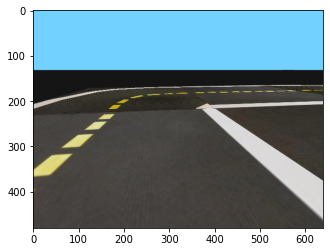

In [18]:
env.reset()
for i in range(10):

    lane_pose = env.get_lane_pos2(env.cur_pos, env.cur_angle)
    distance_to_road_center = lane_pose.dist
    angle_from_straight_in_rads = lane_pose.angle_rad
    
    k_p = 10
    k_d = 1
    speed = 0.5 
    steering = k_p*distance_to_road_center + k_d*angle_from_straight_in_rads
    
    obs, reward, done, info = env.step([speed, steering])
    plt.imshow(obs)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break
ipythondisplay.clear_output(wait=True)